In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

In [2]:
climyrs=[1993,2023]
qtile=0.90

In [3]:
cluster = LocalCluster(n_workers=6,threads_per_worker=1,dashboard_address='localhost:54924')
client = Client(cluster)

In [4]:
flistclim = [fnameCanESMClim(workdir,climyrs[0],climyrs[-1],mm) for mm in range(1,13)]
fclim=xr.open_mfdataset(flistclim,combine='nested',concat_dim='month',parallel=True,decode_times=False)

In [5]:
SST=fclim.tso.data.rechunk([1,-1,90,120])
SST

dask.array<rechunk-merge, shape=(12, 215, 180, 360), dtype=float64, chunksize=(1, 215, 90, 120), chunktype=numpy.ndarray>

### inflection points, before:

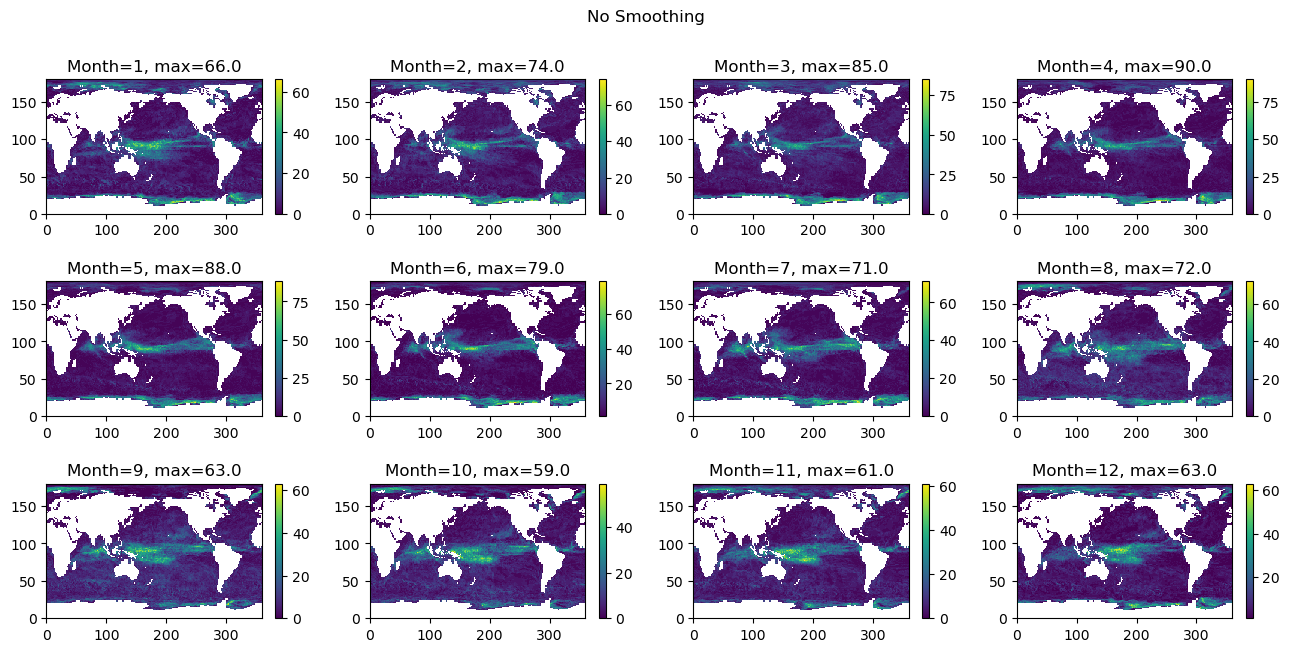

In [6]:
def countswitch(vals):
    sgn=da.sign(da.diff(vals,axis=1)).compute()
    count=np.zeros((12,180,360))
    for il in range(1,len(fclim.leadtime.values)-1):
        count=count+(sgn[:,il,:,:]!=sgn[:,il-1,:,:]).astype(int)
    count=np.ma.masked_where(np.isnan(SST[:,0,:,:]),count)
    return count
count=countswitch(SST)
fig,ax=plt.subplots(3,4,figsize=(16,7),gridspec_kw={'hspace':.5,'wspace':.2})
ax=ax.flatten()
for ix in range(0,12):
    m=ax[ix].pcolormesh(count[ix,...])
    fig.colorbar(m,ax=ax[ix])
    ax[ix].set_title(f"Month={ix+1}, max={np.max(count[ix,...])}")
fig.suptitle('No Smoothing');

this version reduces L at the edges

In [7]:
def _add_dims(arr,tarr):
    while len(np.shape(arr))<len(np.shape(tarr)):
        arr=np.expand_dims(arr,-1)
    return arr
    
def gsmooth(t,vals,L=30):
    # t is values assoc with 1st dim
    # smooths over 1st dim
    # if vector, add dim:
    dt=t[1]-t[0]
    alpha=1
    if len(np.shape(vals))==1:
        vals=np.expand_dims(vals,axis=1)
    fil=np.empty(np.shape(vals))
    for ind, ti in enumerate(t):
        diff=np.abs(ti-t)
        Leff=min(L,alpha*(ti-t[0]+1)*dt,alpha*(t[-1]-ti+1)*dt)# do not smooth beginning and end as strongly
        s=Leff/2.355
        weight=_add_dims(np.array([np.exp(-.5*x**2/s**2) if x <=3*Leff else 0.0 for x in diff]),vals)
        fil[ind,...]=np.divide(np.nansum(weight*vals,0),np.nansum(weight*~np.isnan(vals),0),
                               out=np.nan*da.array(np.ones(np.shape(vals)[1:])),
                               where=np.nansum(weight*~np.isnan(vals),0)>0)
    return fil

In [8]:
climS={}
for L in (10,15,20,30):
    climS[L]=da.empty_like(fclim.tso)
    for ix in range(0,12):
        climS[L][ix,...]=da.map_blocks(gsmooth,fclim.leadtime.values/24,SST[ix,...],L,dtype=float)
    start=dt.datetime.now()
    climS[L]=climS[L].persist()
    wait(climS[L])
    end=dt.datetime.now()
    print(end-start)

0:04:38.289321
0:04:30.988361
0:04:35.846227
0:04:34.198465


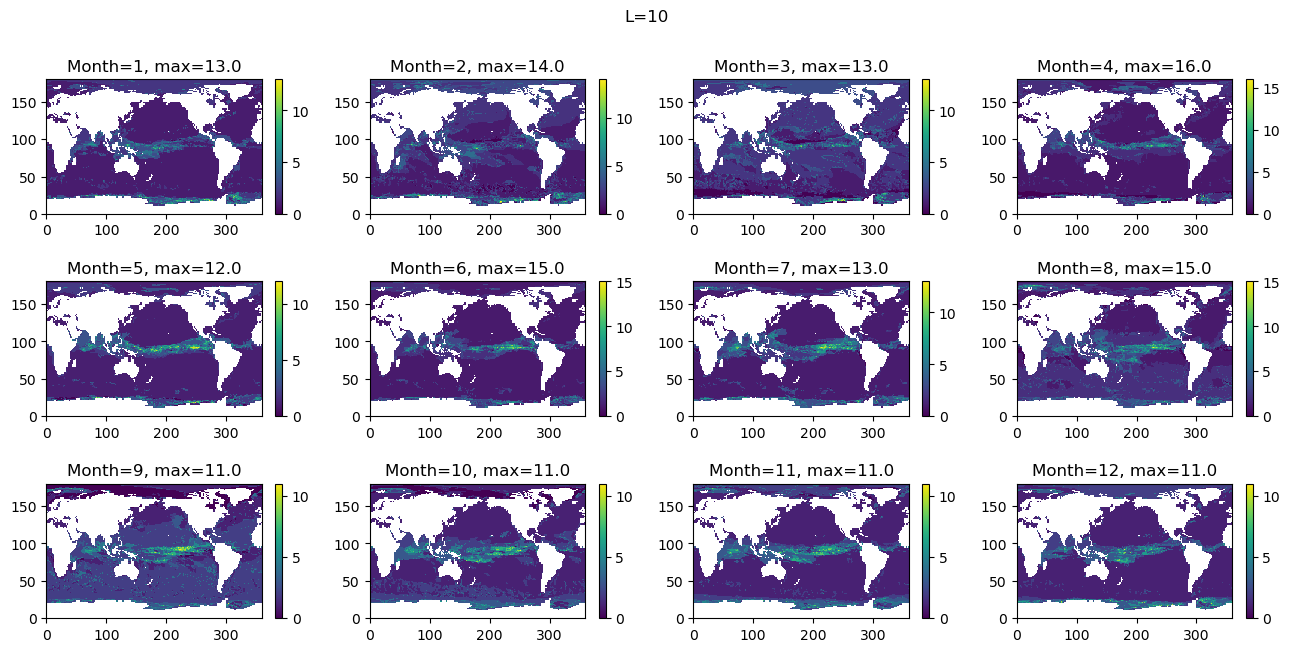

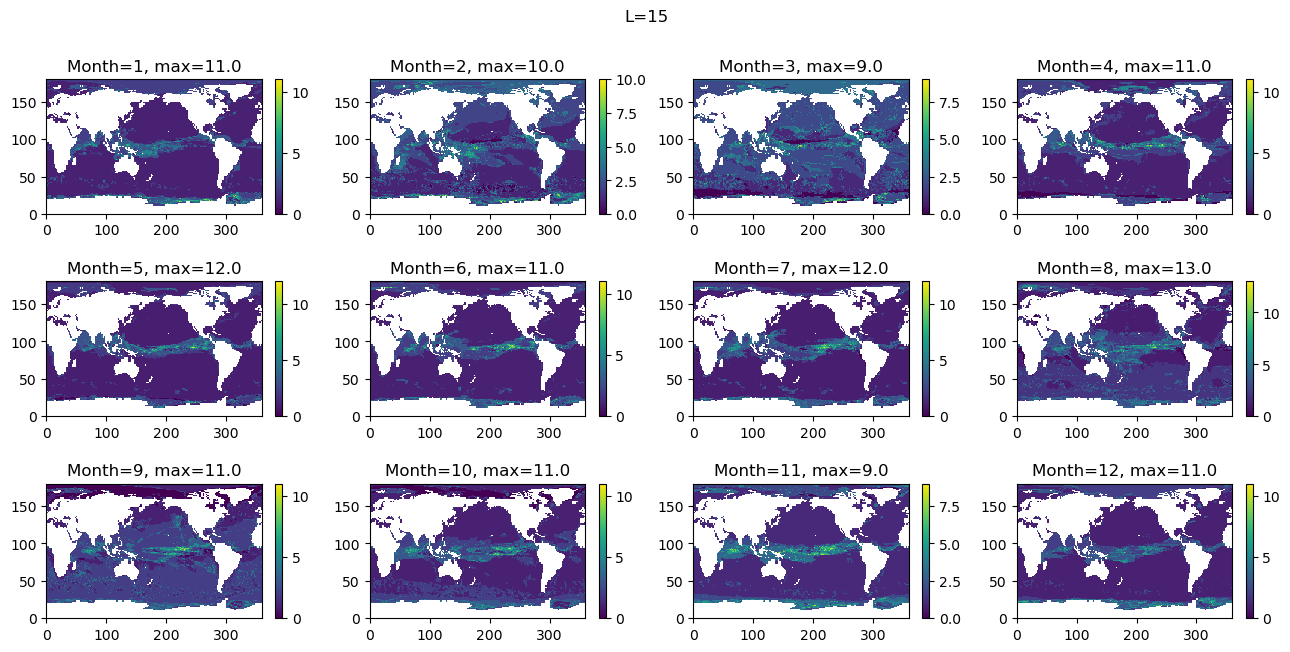

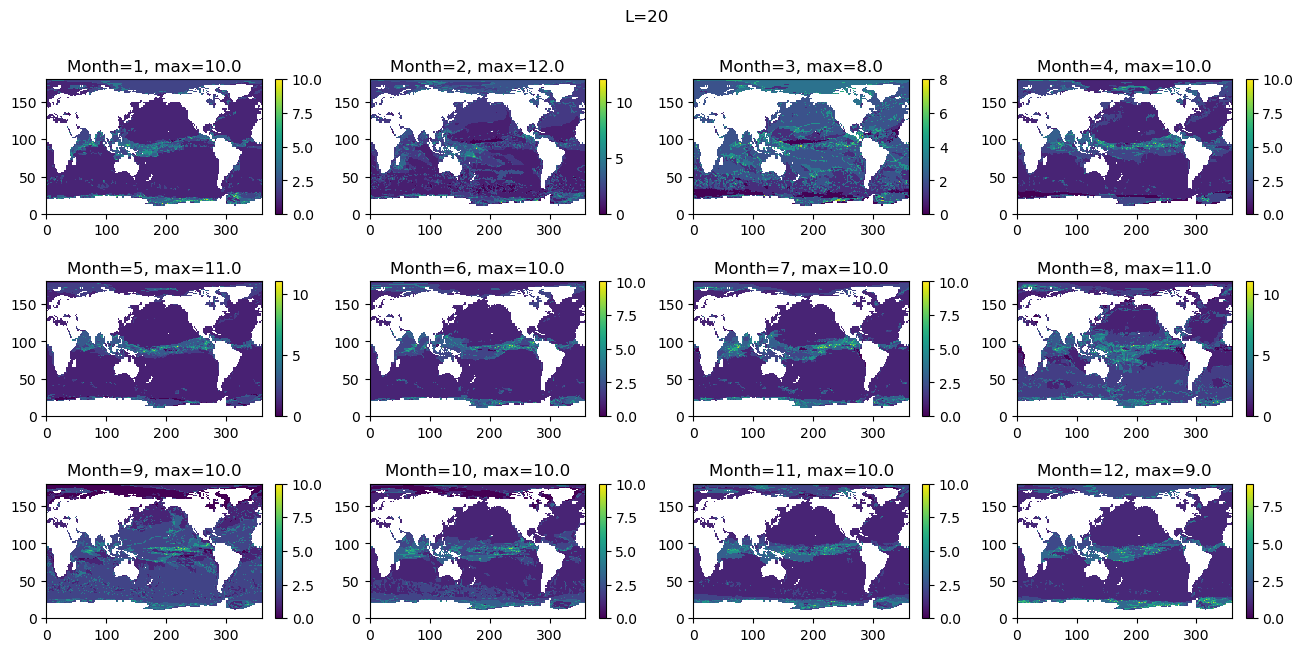

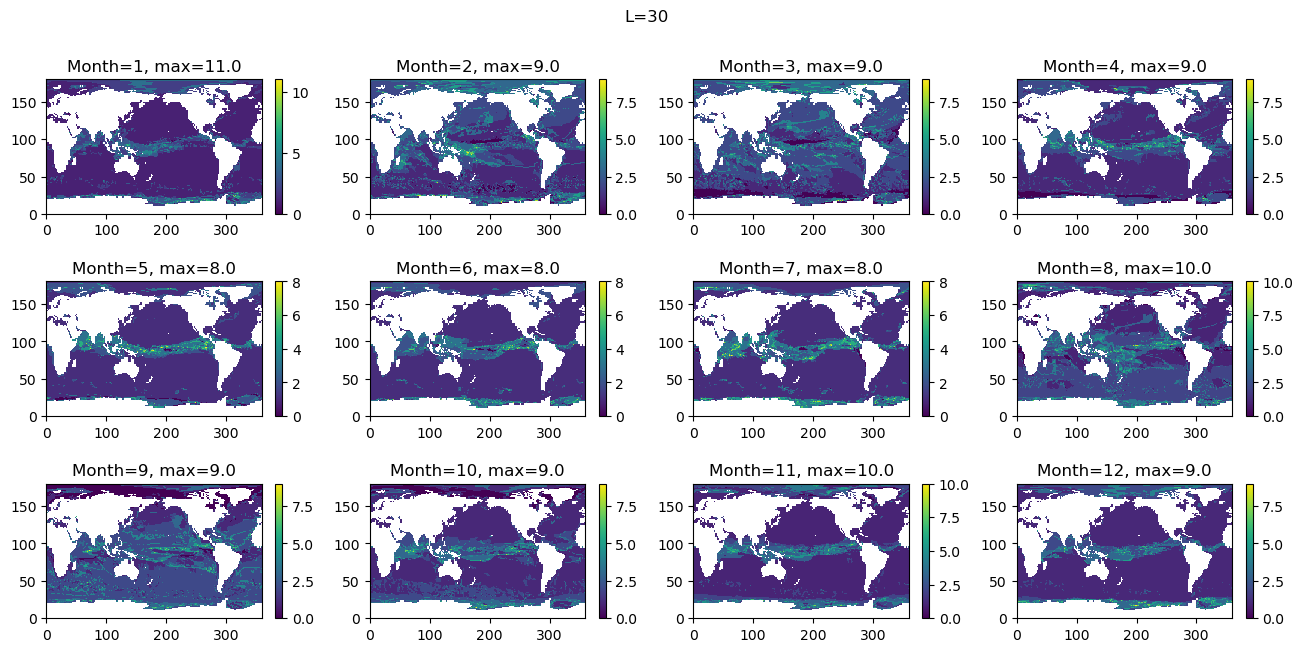

In [9]:
count={}
for L in (10,15,20,30):
    count[L]=countswitch(climS[L])
    fig,ax=plt.subplots(3,4,figsize=(16,7),gridspec_kw={'hspace':.5,'wspace':.2})
    ax=ax.flatten()
    for ix in range(0,12):
        m=ax[ix].pcolormesh(count[L][ix,...])
        fig.colorbar(m,ax=ax[ix])
        ax[ix].set_title(f"Month={ix+1}, max={np.max(count[L][ix,...])}")
    fig.suptitle(f'L={L}');

In [10]:
count[10][7,94,210:225]

masked_array(data=[7.0, 8.0, 8.0, 6.0, 5.0, 5.0, 7.0, 7.0, 9.0, 9.0, 9.0,
                   9.0, 11.0, 11.0, 9.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=1e+20)

In [11]:
count[10][7,94,224]

np.float64(9.0)

In [12]:
class gloc:
    def __init__(self,name,j,i):
        self.name=name
        self.j=j
        self.i=i
loc1=gloc('Equatorial Pacific',94,224)
loc2=gloc('North Atlantic',145,350)

Text(0, 0.5, 'SST (K)')

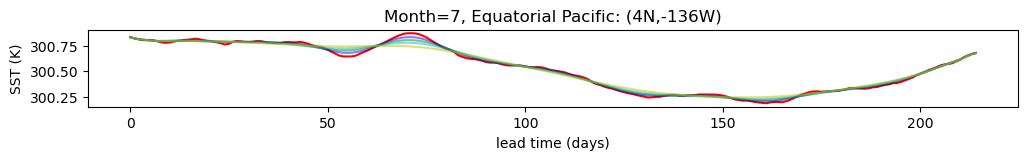

In [13]:
loc=loc1
fig,ax=plt.subplots(1,1,figsize=(12,1))
ax.plot(           SST[7,:,loc.j,loc.i],     'r-',         label='No Smoothing')
ax.plot(np.array(climS[10][7,:,loc.j,loc.i]),'b-',alpha=.5,label='L=10')
ax.plot(np.array(climS[15][7,:,loc.j,loc.i]),'g-',alpha=.5,label='L=15')
ax.plot(np.array(climS[20][7,:,loc.j,loc.i]),'c-',alpha=.5,label='L=20')
ax.plot(np.array(climS[30][7,:,loc.j,loc.i]),'y-',alpha=.5,label='L=30')
ax.set_title(f'Month=7, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
ax.set_xlabel('lead time (days)')
ax.set_ylabel('SST (K)')
#ax.legend()

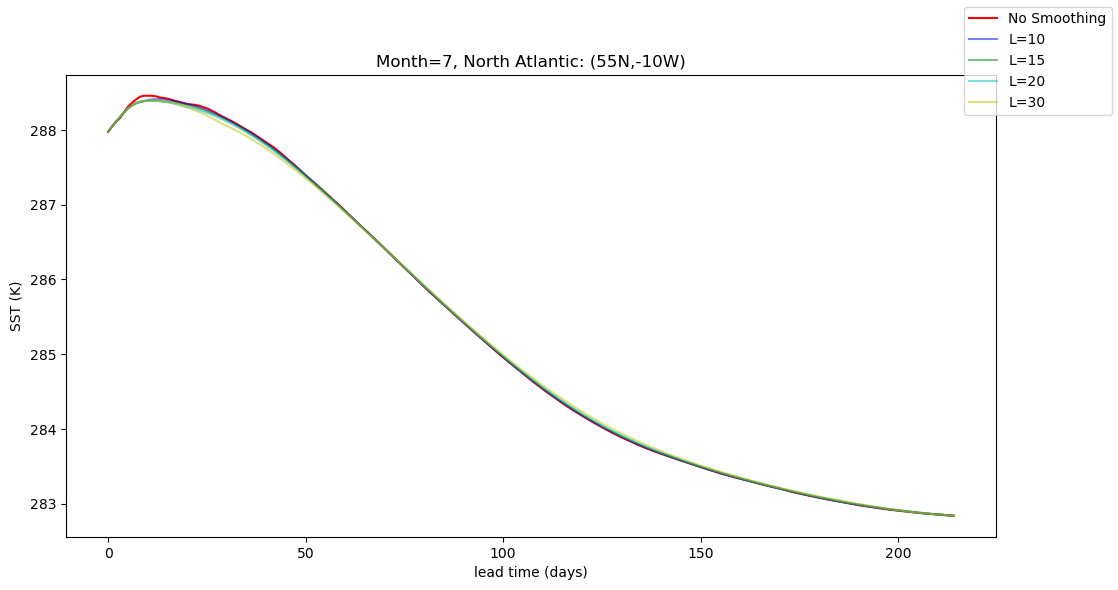

In [14]:
loc=loc2
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(           SST[7,:,loc.j,loc.i],     'r-',         label='No Smoothing')
ax.plot(np.array(climS[10][7,:,loc.j,loc.i]),'b-',alpha=.5,label='L=10')
ax.plot(np.array(climS[15][7,:,loc.j,loc.i]),'g-',alpha=.5,label='L=15')
ax.plot(np.array(climS[20][7,:,loc.j,loc.i]),'c-',alpha=.5,label='L=20')
ax.plot(np.array(climS[30][7,:,loc.j,loc.i]),'y-',alpha=.5,label='L=30')
ax.set_title(f'Month=7, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
ax.set_xlabel('lead time (days)')
ax.set_ylabel('SST (K)')
fig.legend()

##### Compare Climatology Visualizations

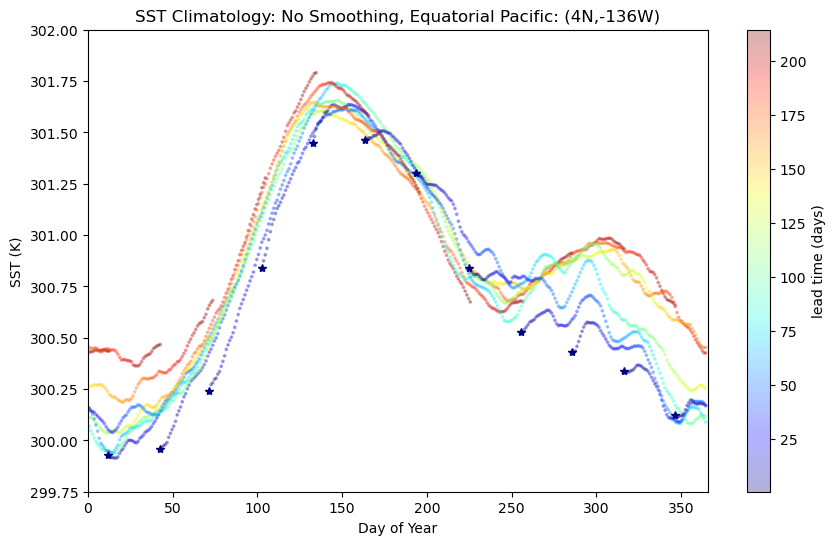

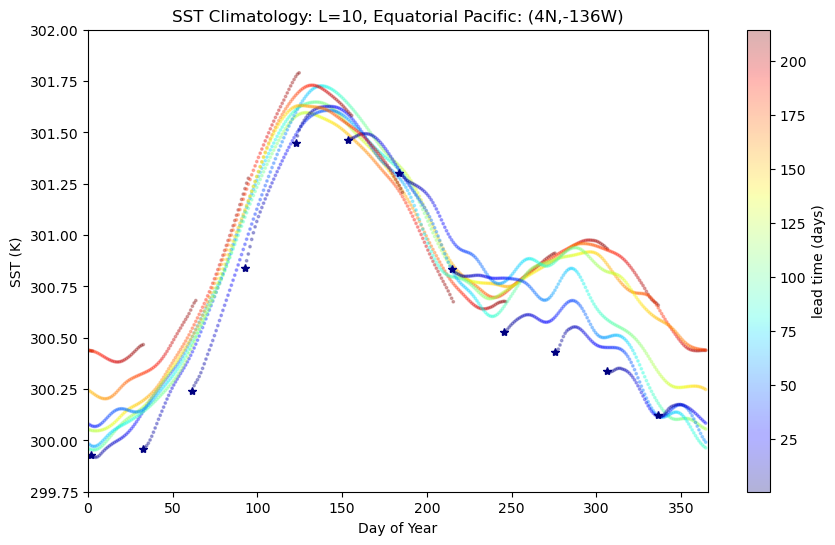

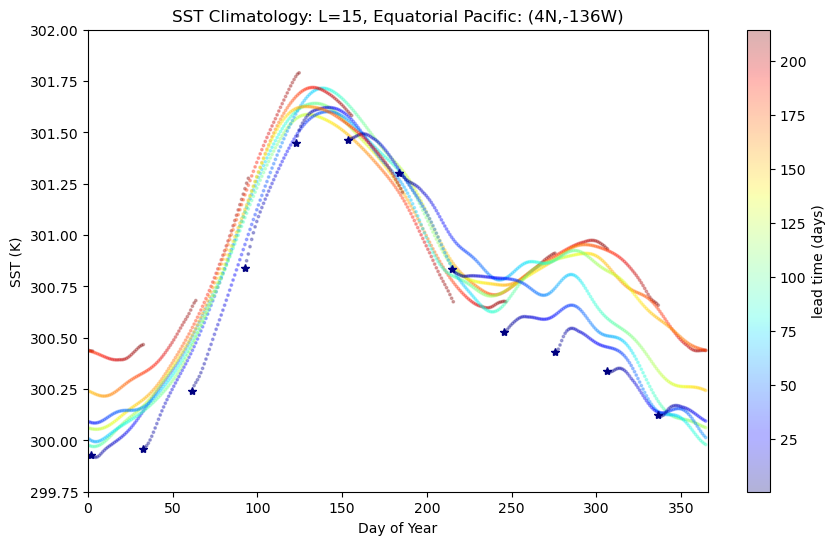

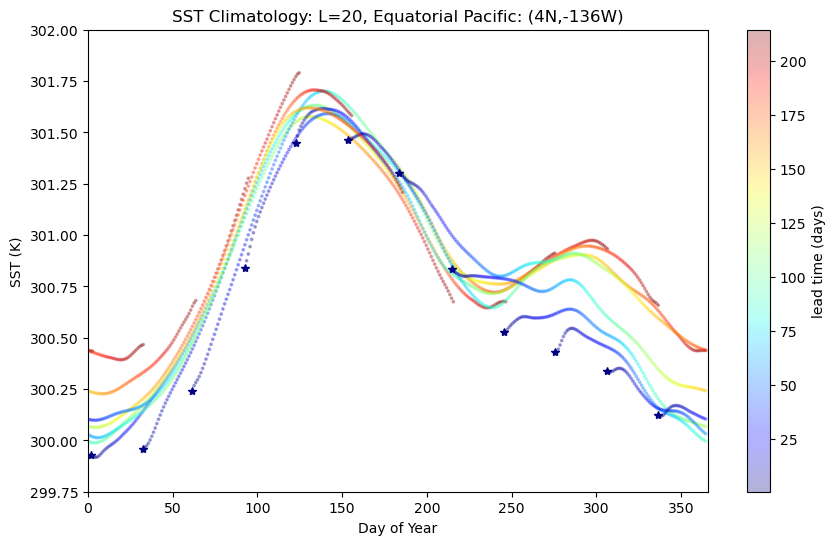

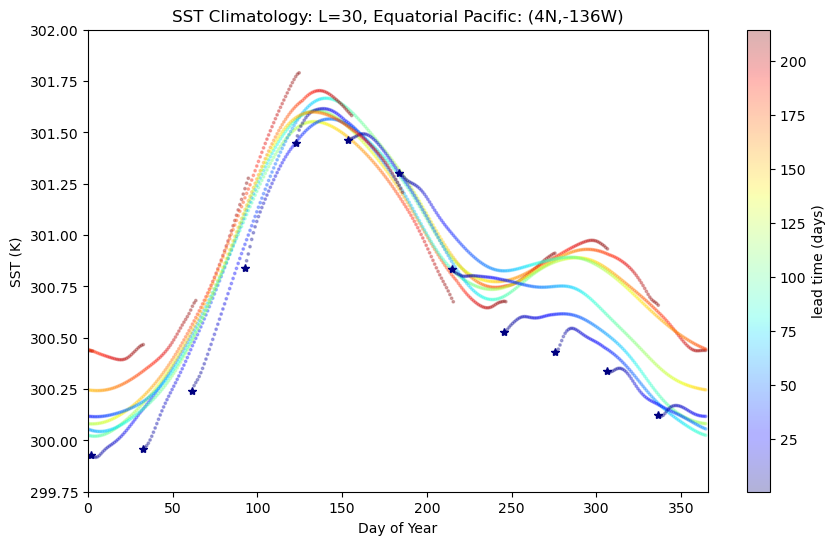

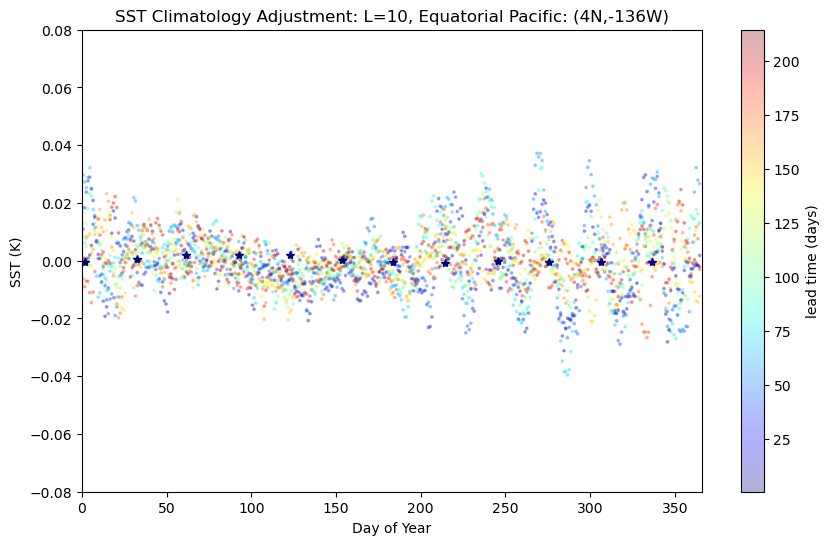

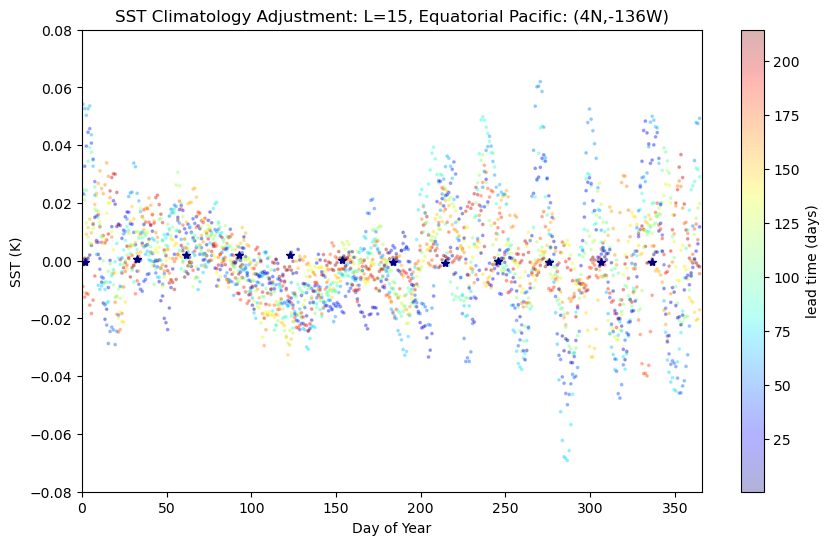

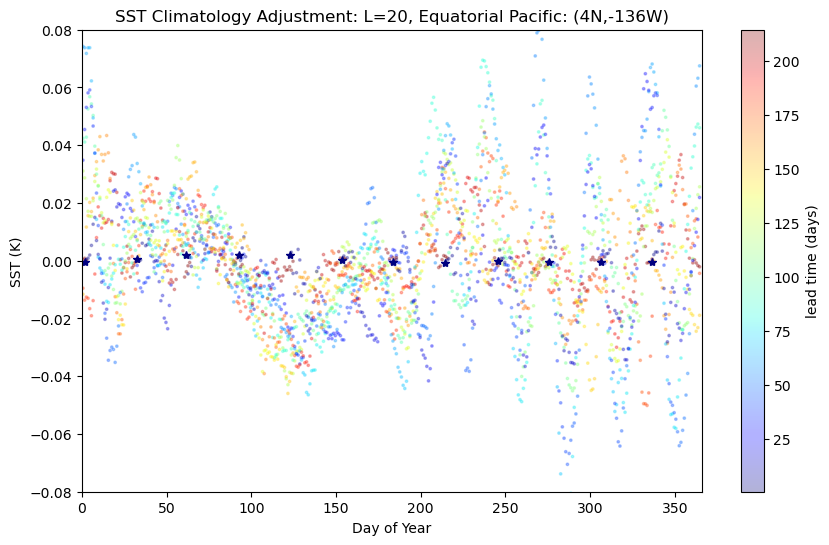

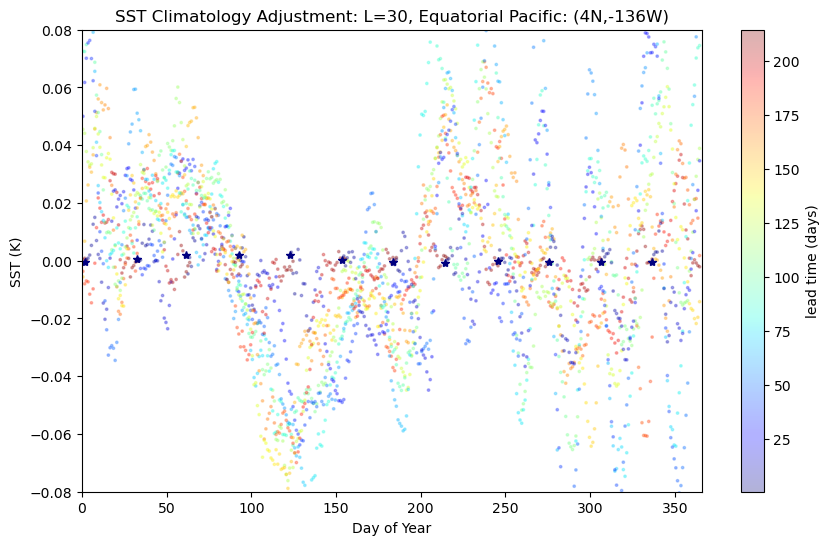

In [15]:
loc=loc1
# unsmoothed
fig,ax=plt.subplots(1,1,figsize=(10,6))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
    t=t%365
    m=ax.scatter(t,SST[mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
    ax.plot(t[0],SST[mm-1,0,loc.j,loc.i],'*',color='navy')
fig.colorbar(m,label='lead time (days)')
ax.set_title(f'SST Climatology: No Smoothing, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)
ax.set_ylim(299.75,302)

# smoothed climatologies
for L in (10,15,20,30):
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for mm in range(1,13):
        t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
        t=t%365
        m=ax.scatter(t,climS[L][mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
        ax.plot(t[0],climS[L][mm-1,0,loc.j,loc.i],'*',color='navy')
    fig.colorbar(m,label='lead time (days)')
    ax.set_title(f'SST Climatology: L={L}, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('SST (K)')
    ax.set_xlim(0,366)
    ax.set_ylim(299.75,302)
    
# adjustments
for L in (10,15,20,30):
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for mm in range(1,13):
        t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
        t=t%365
        m=ax.scatter(t,climS[L][mm-1,:,loc.j,loc.i]-SST[mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
        ax.plot(t[0],climS[L][mm-1,0,loc.j,loc.i]-SST[mm-1,0,loc.j,loc.i],'*',color='navy')
    fig.colorbar(m,label='lead time (days)')
    ax.set_title(f'SST Climatology Adjustment: L={L}, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('SST (K)')
    ax.set_xlim(0,366)
    ax.set_ylim(-.08,.08)

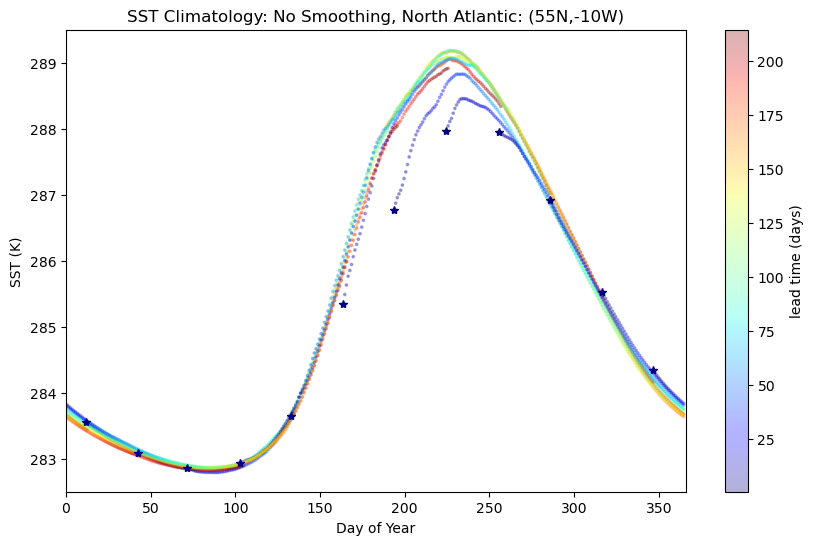

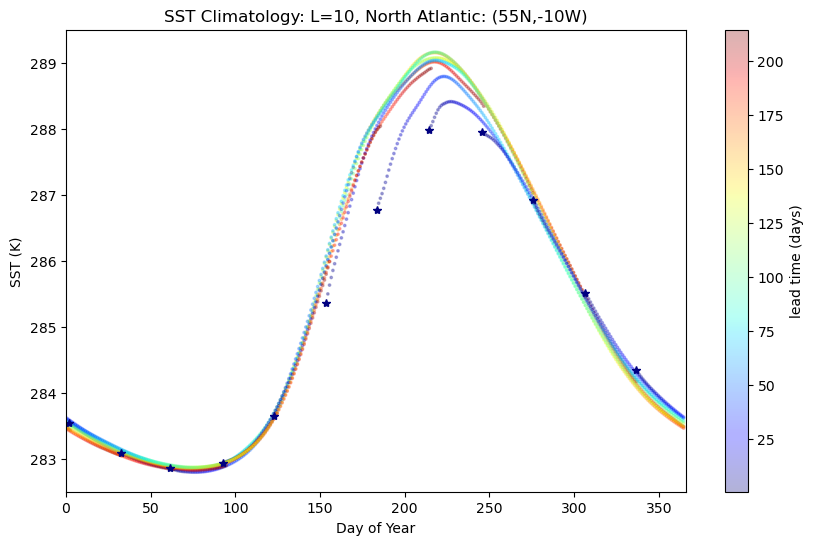

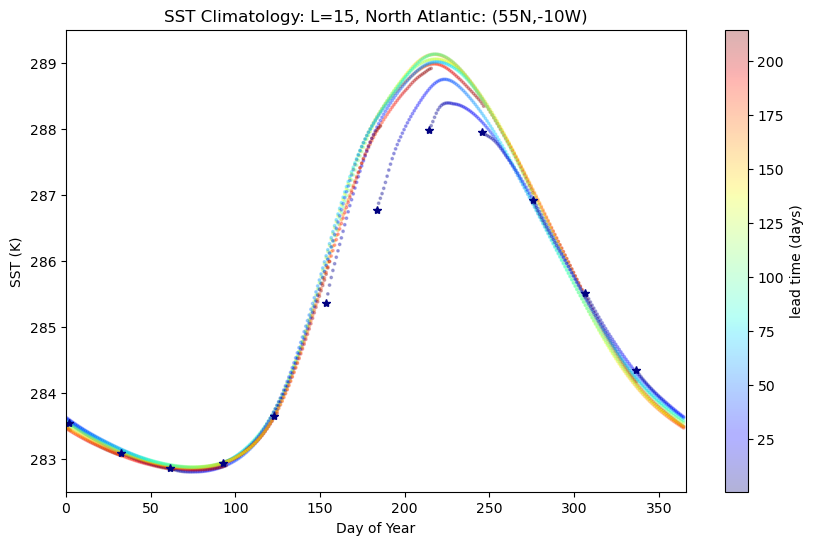

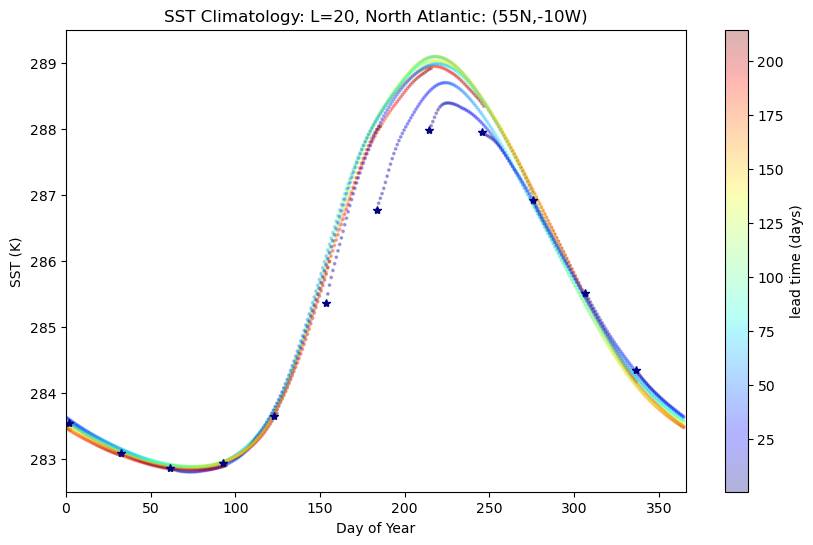

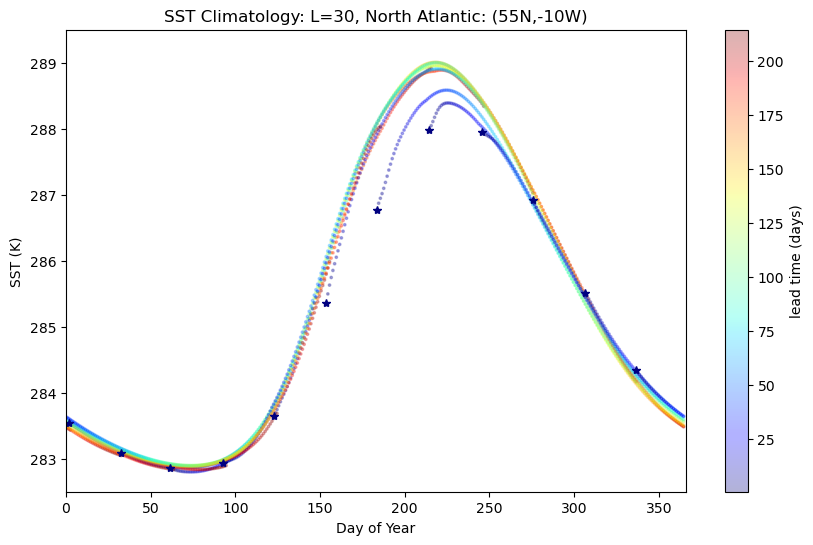

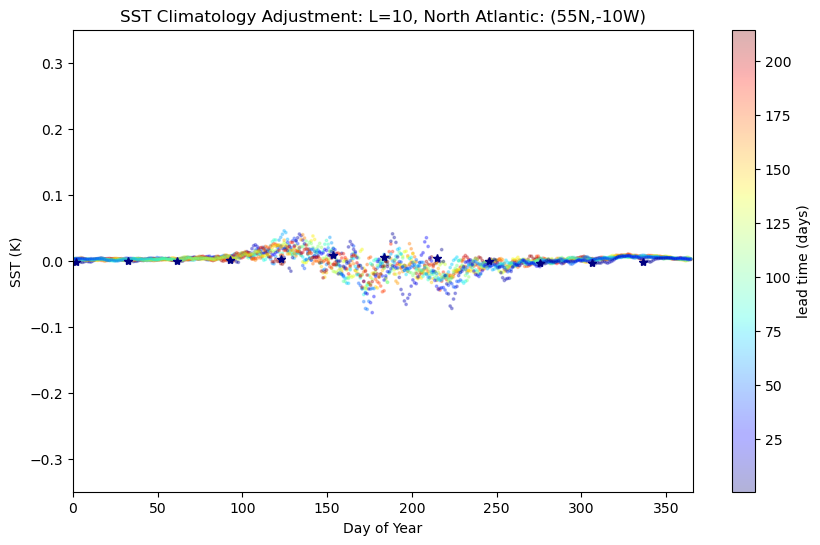

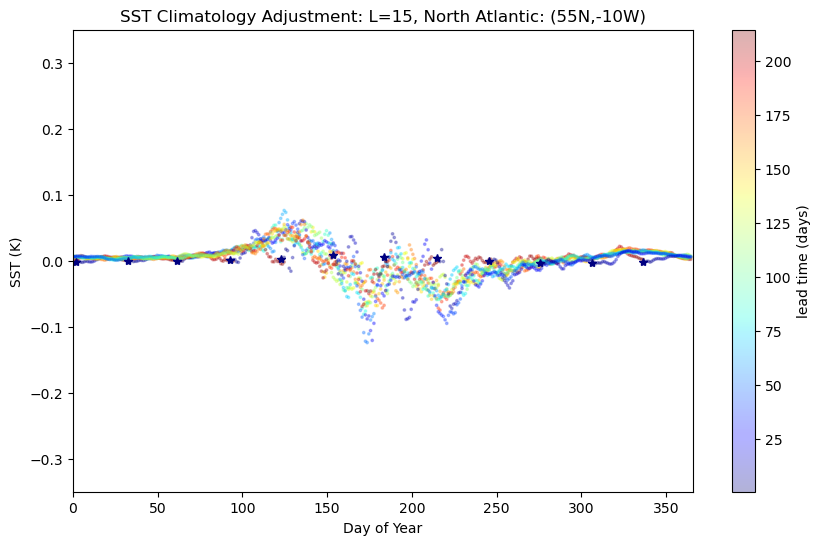

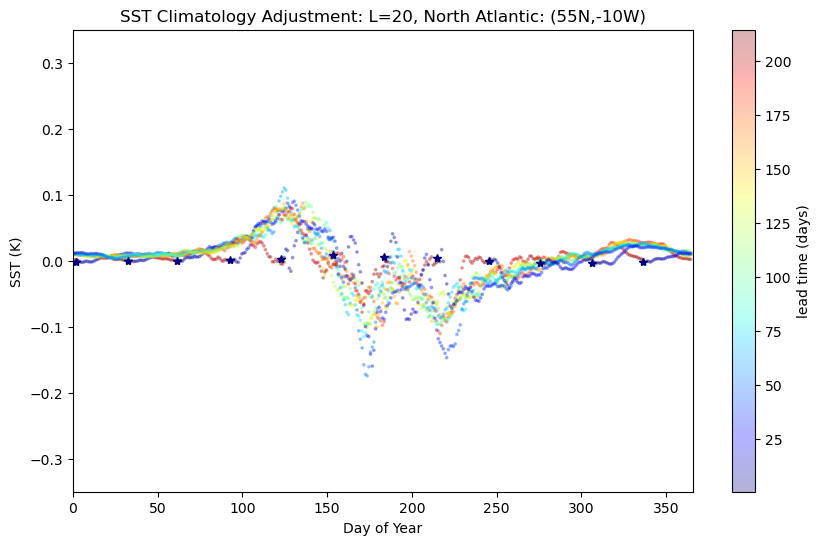

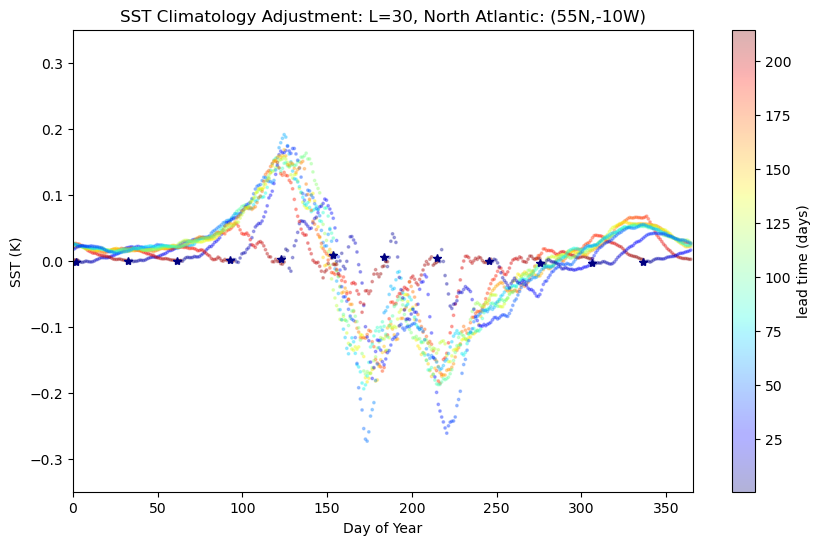

In [17]:
loc=loc2
# unsmoothed
fig,ax=plt.subplots(1,1,figsize=(10,6))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
    t=t%365
    m=ax.scatter(t,SST[mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
    ax.plot(t[0],SST[mm-1,0,loc.j,loc.i],'*',color='navy')
fig.colorbar(m,label='lead time (days)')
ax.set_title(f'SST Climatology: No Smoothing, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)
ax.set_ylim(282.5,289.5)

# smoothed climatologies
for L in (10,15,20,30):
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for mm in range(1,13):
        t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
        t=t%365
        m=ax.scatter(t,climS[L][mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
        ax.plot(t[0],climS[L][mm-1,0,loc.j,loc.i],'*',color='navy')
    fig.colorbar(m,label='lead time (days)')
    ax.set_title(f'SST Climatology: L={L}, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('SST (K)')
    ax.set_xlim(0,366)
    ax.set_ylim(282.5,289.5)
    
# adjustments
for L in (10,15,20,30):
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for mm in range(1,13):
        t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
        t=t%365
        m=ax.scatter(t,climS[L][mm-1,:,loc.j,loc.i]-SST[mm-1,:,loc.j,loc.i],c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
        ax.plot(t[0],climS[L][mm-1,0,loc.j,loc.i]-SST[mm-1,0,loc.j,loc.i],'*',color='navy')
    fig.colorbar(m,label='lead time (days)')
    ax.set_title(f'SST Climatology Adjustment: L={L}, {loc.name}: ({loc.j-90}N,{loc.i-360}W)')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('SST (K)')
    ax.set_xlim(0,366)
    ax.set_ylim(-.35,.35)

In [18]:
fclim.close()